<a href="https://colab.research.google.com/github/EmadUSyed/Plasma-Instability-in-Fusion-Simulations/blob/main/Fusion_Starter_(ML_model_Gradient_Boosting_Classifier).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    PrecisionRecallDisplay, precision_recall_curve, auc, recall_score)
from xgboost import XGBClassifier
import time
from google.colab import drive
drive.mount("/content/drive")

# ==============================================
# 1. Data Loading & Preprocessing
# ==============================================
def load_and_visualize():
    # Load data
    fusion = pd.read_csv('/content/drive/Shareddrives/Data322/phase_data_with_stability.csv')
    fusion = fusion[fusion['folder_name'] != 'v2_2']

    # Create dataset summary visualization
    plt.figure(figsize=(12, 6))

    # Plot 1: Velocity distribution by stability status
    plt.subplot(1, 2, 1)
    sns.kdeplot(fusion[fusion['is_unstable'] == 0]['velocity'],
                label='Stable', fill=True)
    sns.kdeplot(fusion[fusion['is_unstable'] == 1]['velocity'],
                label='Unstable', fill=True)
    plt.title('Velocity Distribution by Stability Status')
    plt.xlabel('Velocity')
    plt.ylabel('Density')

    # Plot 2: Instability onset timing
    plt.subplot(1, 2, 2)
    unstable_times = fusion[fusion['is_unstable'] == 1].groupby('folder_name')['time_step'].min()
    unstable_times.value_counts().sort_index().plot(kind='bar', color='maroon')
    plt.title('First Instability Occurrence by Simulation')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Simulations')

    plt.tight_layout()
    plt.savefig('dataset_summary.png', dpi=300)
    plt.show()

    return fusion


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ==============================================
# 2. Feature Engineering
# ==============================================
def preprocess_data(df):
    # Sort data for temporal operations
    df.sort_values(['folder_name', 'particle_index', 'time_step'], inplace=True)

    # Create 3-step-ahead target
    df['target'] = df.groupby(['folder_name', 'particle_index'])['is_unstable'].shift(-3).fillna(0)

    # Aggregate to simulation-level features
    aggregated = df.groupby(['folder_name', 'time_step']).agg({
        'position': ['mean', 'std', 'min', 'max'],
        'velocity': ['mean', 'std', 'min', 'max'],
        'target': 'max'
    }).reset_index()

    # Flatten multi-index columns
    aggregated.columns = ['folder_name', 'time_step'] + [
        f'{col[0]}_{col[1]}' for col in aggregated.columns[2:]
    ]

    # Create temporal features
    lags = [1, 2, 3]
    features_to_lag = ['velocity_mean', 'velocity_std', 'position_mean', 'position_std']

    for feature in features_to_lag:
        for lag in lags:
            aggregated[f'{feature}_lag{lag}'] = aggregated.groupby('folder_name')[feature].shift(lag)
            aggregated[f'{feature}_diff{lag}'] = aggregated[feature] - aggregated[f'{feature}_lag{lag}']

    aggregated.dropna(inplace=True)
    return aggregated


In [3]:
# ==============================================
# 3. Model Training & Evaluation
# ==============================================
def train_and_evaluate(processed_data):
    X = processed_data.drop(columns=['folder_name', 'time_step', 'target_max'])
    y = processed_data['target_max']
    groups = processed_data['folder_name']

    metrics = {
        'roc_auc': [], 'pr_auc': [], 'recall': [],
        'precision': [], 'lead_times': [], 'inference_times': []
    }

    gkf = GroupKFold(n_splits=3)

    for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        ratio = len(y_train[y_train == 0])/len(y_train[y_train == 1])
        model = XGBClassifier(
            scale_pos_weight=ratio,
            eval_metric='logloss',
            use_label_encoder=False,
            n_estimators=200,
            max_depth=5
        )

        model.fit(X_train, y_train)

        # Inference timing
        start = time.time()
        y_proba = model.predict_proba(X_test)[:, 1]
        metrics['inference_times'].append((time.time()-start)/len(X_test))

        # Calculate metrics
        metrics['roc_auc'].append(roc_auc_score(y_test, y_proba))
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        metrics['pr_auc'].append(auc(recall, precision))

        # Generate plots
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'Fold {fold+1} (AUC = {metrics["roc_auc"][-1]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Fold {fold+1} ROC Curve')

        plt.subplot(1, 2, 2)
        PrecisionRecallDisplay.from_predictions(y_test, y_proba)
        plt.title(f'Fold {fold+1} PR Curve (AUC = {metrics["pr_auc"][-1]:.2f})')
        plt.tight_layout()
        plt.savefig(f'fold{fold+1}_curves.png', dpi=300)
        plt.show()

    # Print final metrics
    print("\nAverage Performance:")
    print(f"ROC AUC: {np.mean(metrics['roc_auc']):.3f} ± {np.std(metrics['roc_auc']):.3f}")
    print(f"PR AUC: {np.mean(metrics['pr_auc']):.3f} ± {np.std(metrics['pr_auc']):.3f}")
    print(f"Inference Time: {np.mean(metrics['inference_times'])*1e6:.2f} μs/prediction")

In [4]:
# ==============================================
# 4. Sample Size Calculation
# ==============================================
def calculate_sample_size():
    z = 1.96  # 95% confidence
    p = 0.5    # Conservative estimate
    E = 0.05   # 5% margin of error

    n = (z**2 * p * (1-p)) / E**2
    print(f"\nRequired simulations for {E*100}% margin of error: {np.ceil(n):.0f}")

Loading and visualizing dataset...


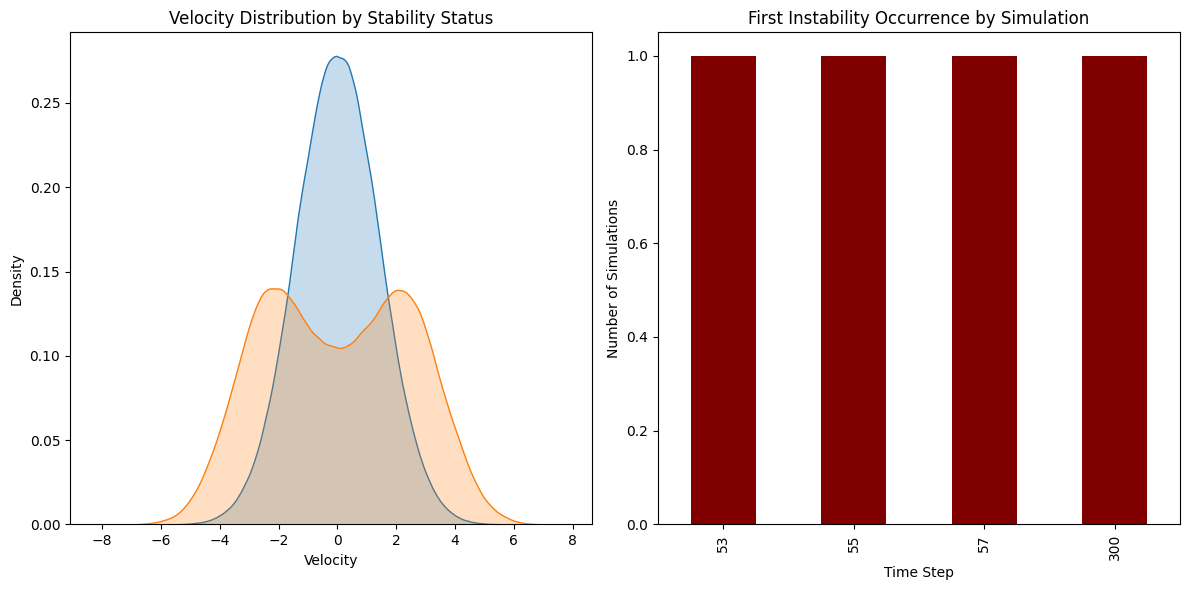


Preprocessing data...

Training model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:37:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


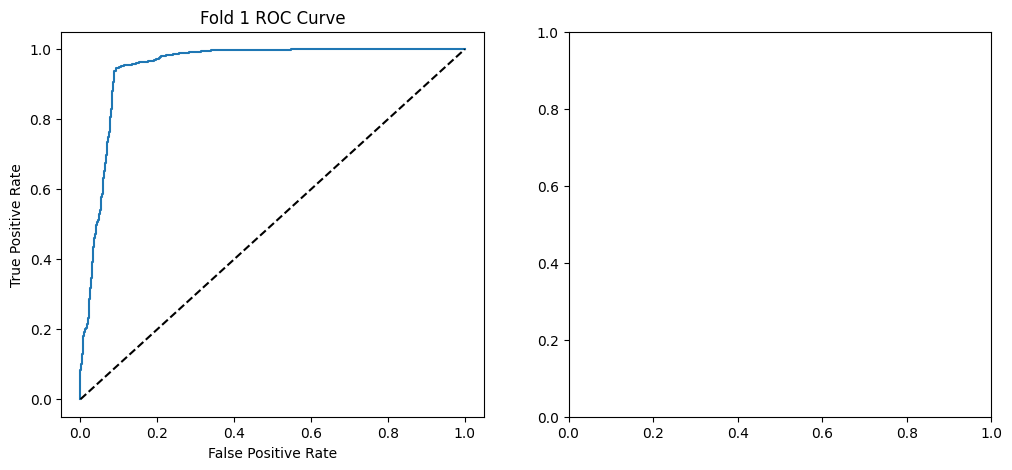

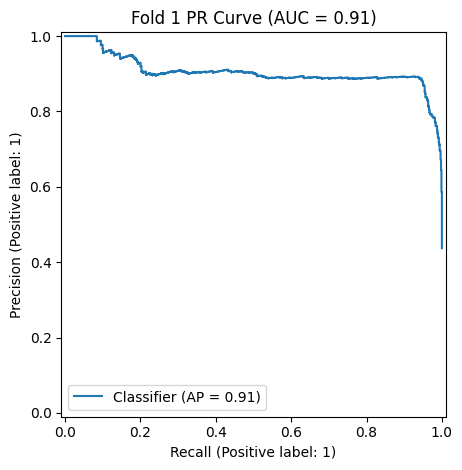

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:37:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


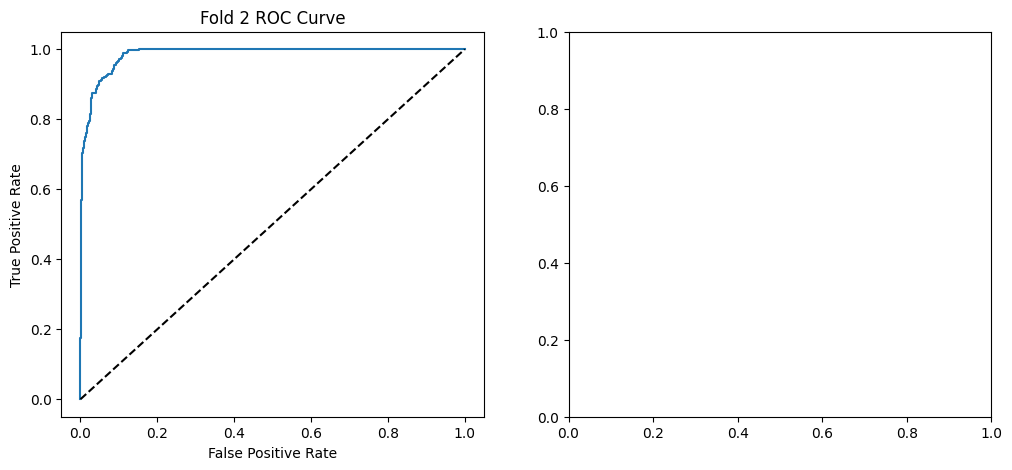

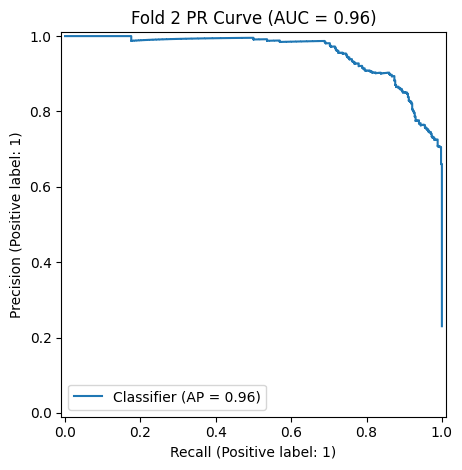

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:37:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


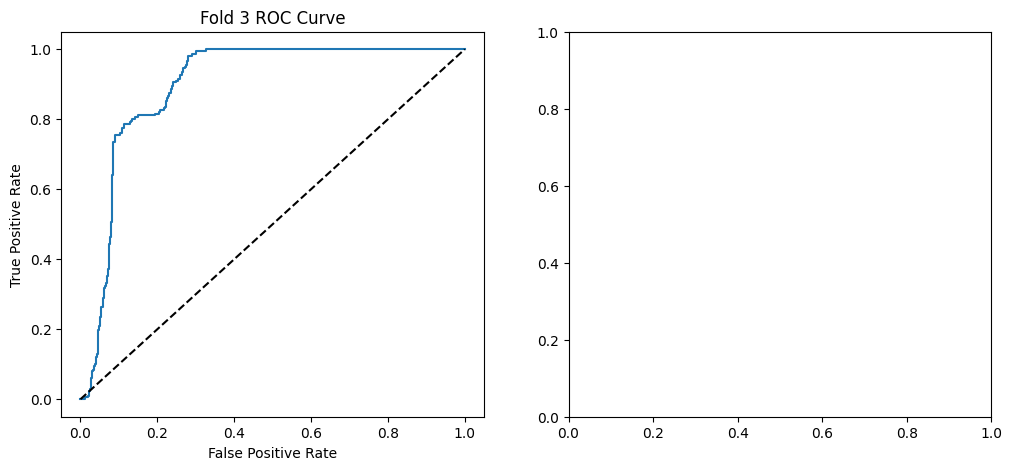

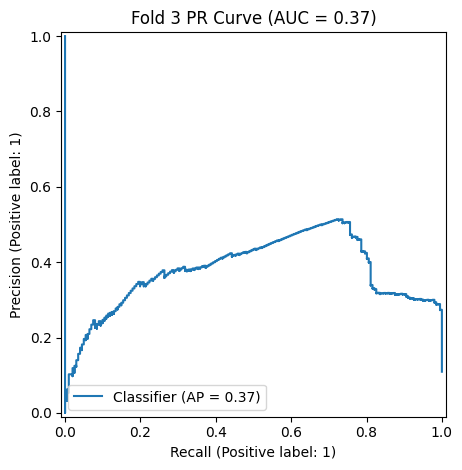


Average Performance:
ROC AUC: 0.944 ± 0.036
PR AUC: 0.743 ± 0.266
Inference Time: 7.21 μs/prediction

Required simulations for 5.0% margin of error: 385


In [5]:
# ==============================================
# Main Execution
# ==============================================
if __name__ == "__main__":
    # Load and visualize data
    print("Loading and visualizing dataset...")
    fusion_data = load_and_visualize()

    # Preprocess and create features
    print("\nPreprocessing data...")
    processed_data = preprocess_data(fusion_data)

    # Train and evaluate model
    print("\nTraining model...")
    train_and_evaluate(processed_data)

    # Sample size calculation
    calculate_sample_size()

Notice that there are 10,000 particles per folder, there are 13 folders with between 148 and 501 timepoints each. Of these 13 folders, 8 folders are always stable and 5 become unstable at various times, ranging from 53 to 375.  The project instructions said to remove v2_2 from the dataset so I'll do that next: